In [168]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
# from scipy import integrate
from sympy import integrate
from scipy.linalg import eig

In [169]:
nat_freq = np.loadtxt('P2024_f_Part4.txt')
modes = np.loadtxt('P2024_Modes_Part4.txt')

x = sp.symbols('x')

In [170]:
l = 0.8
a = 0.2
L = l+2*a

e = 0.15
t = 0.01
d = 0.25
rho = 7850
A = e**2 - (e-2*t)**2
E = 210e9
I = (e**4 - (e-2*t)**4)/12

M_mot = 75.2
M_dv = 75
J_B = 1
J_D = 10
k_1l = 1e4  # N/m
k_1r = 1e9  # Nm/rad attention
k_2l = 1e5
k_2r = 1e4

Fonction de Rayleigh-Ritz polynomiale (p) ou harmonique (h)


In [171]:
def phi(x, n, form="p"):
    if form == "p":
        f = (x/L)**n
    if form == "h":
        f = sp.sin(n*np.pi*x/L)
    return f

# phi en metres
# d phi/ dx = theta en radians avec les petits angles

Matrice de masses


In [172]:
def Mass(N):

    B = l/2
    D = l + a
    M = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            M[i, j] = (integrate(rho * A * phi(x, i) * phi(x, j), (x, 0, L))
                       + M_mot * phi(B, i) * phi(B, j)
                       + M_mot * d**2 *
                       sp.diff(phi(B, i), x) * sp.diff(phi(B, j), x)
                       + J_B * sp.diff(phi(B, i), x) * sp.diff(phi(B, j), x)
                       + M_dv * phi(D, i) * phi(D, j)
                       + J_D * sp.diff(phi(D, i), x) * sp.diff(phi(D, j), x))

    return M

Matrices de raideurs

In [173]:
def Stiff(N):

    A_pos = 0
    C = l
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = (integrate(E * I * sp.diff(phi(x, i), x, x) * sp.diff(phi(x, j), x, x), (x, 0, L))
                       + k_1l * phi(A_pos, i) * phi(A_pos, j)
                       + k_1r * sp.diff(phi(A, i), x) * sp.diff(phi(A, j), x)
                       + k_2l * phi(C, i) * phi(C, j)
                       + k_2r * sp.diff(phi(C, i), x) * sp.diff(phi(C, j), x))

    return K

[3.81]
[  3.81 755.07]
[   3.81  749.47 2386.01]
[3.81000e+00 6.24500e+02 2.38596e+03 6.10593e+03]
[3.81000e+00 6.19510e+02 1.63210e+03 5.95945e+03]
[   3.81  613.24 1632.09 3500.93]
[   3.81  612.35 1566.97 3375.59]
[   3.81  612.28 1564.45 3233.04]
[   3.81  612.24 1562.05 3188.49]


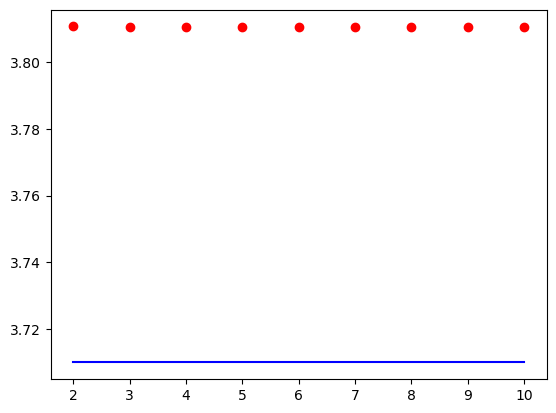

In [174]:
mode_interest = 1
N_min = mode_interest+1
N_max = 10
for N_rr in range(N_min, N_max+1):
    M = Mass(N_rr)
    K = Stiff(N_rr)

    # w[i] is the eigenvalue and U[:, i] is the corresponding eigenvector
    w, U = eig(K, M)

    omega = np.sort(np.abs(np.sqrt(w)))/2/np.pi

    sorted_indices = np.argsort(np.abs(np.sqrt(w)))
    modes = U[:, sorted_indices]

    print(omega[1:5].round(2))

    plt.plot(N_rr, omega[mode_interest], 'ro')

nat_freq_plot = np.linspace(
    nat_freq[mode_interest-1], nat_freq[mode_interest-1], N_max-N_min+1)
plt.plot(range(N_min, N_max+1), nat_freq_plot, 'b')

In [175]:
def modeshape(m, N, U, L, npoints):
    X = np.linspace(0, L, npoints, endpoint=True)
    W = np.zeros(npoints)
    for i in range(0, N):
        for j in range(0, npoints):
            W[j] = W[j] + U[i, m]*phi(X[j], i)
    return W

In [180]:
# parametres pour le plot

nb_points = 10
x_plot = np.linspace(0, L, nb_points)
mode_interest = 1
N_ritz = 15  # il faut que N_ritz > nb_points

(15, 15)


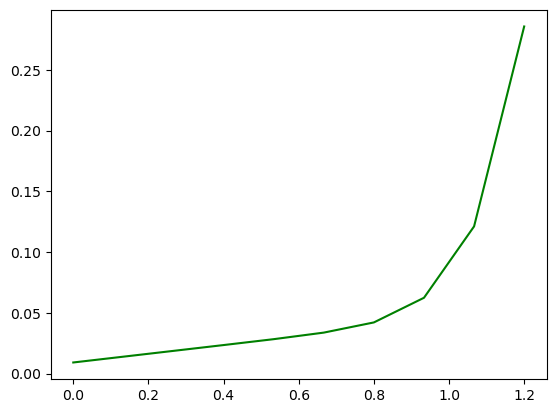

In [181]:
M = Mass(N_ritz)
K = Stiff(N_ritz)
w, U = eig(K, M)
sorted_indices = np.argsort(np.abs(np.sqrt(w)))
modes = U[:, sorted_indices]
print(np.shape(modes))

U_ritz = modeshape(mode_interest, N_rr, modes, L, nb_points)

plt.plot(x_plot, U_ritz, 'g')